In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect the existing database tables into a new model
Base = automap_base()

# Reflect the tables from the database
Base.prepare(engine, reflect=True)


/var/folders/zf/0vbcb4t96mg7ygrsh_n7b7f40000gn/T/ipykernel_20273/3820221497.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("The most recent date in the dataset:", most_recent_date)

The most recent date in the dataset: 2017-08-23


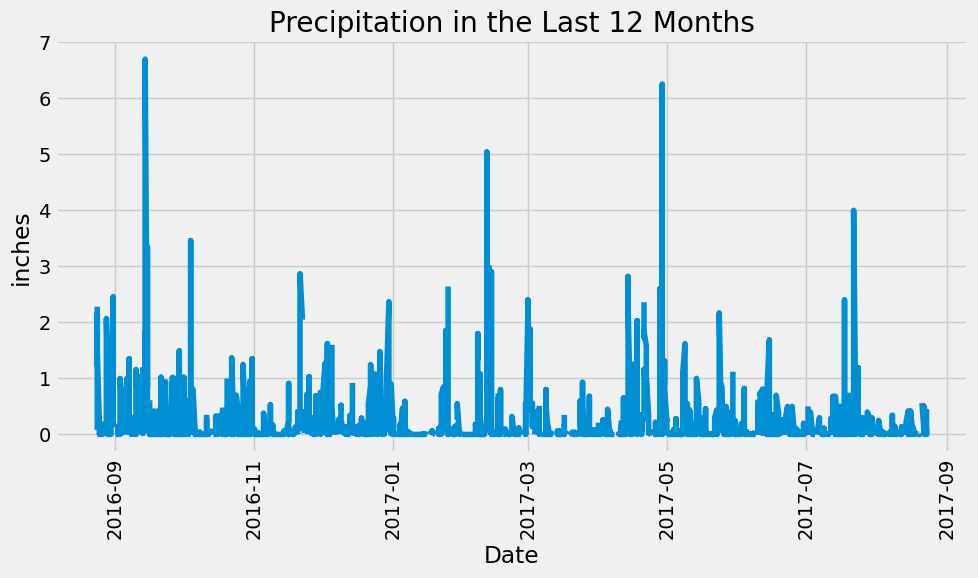

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
from datetime import datetime, timedelta
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                         .filter(Measurement.date >= one_year_ago)\
                         .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'])
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('inches')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
statistics_summary = df['Precipitation'].describe()
statistics_summary

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
print("Total number of stations in the given dataset:", total_stations)


Total number of stations in the given dataset: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count'))\
                             .group_by(Measurement.station)\
                             .order_by(func.count(Measurement.station).desc())\
                             .all()

# List the stations and their counts in descending order.
for station, station_count in most_active_stations:
    print(f"Station: {station}, Count: {station_count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Get the most active stop ID from the previous query
most_active_station_id = most_active_stations[0][0]

# Query to calculate lowest, highest, and average temperatures for the most active station
temps_query = session.query(func.min(Measurement.tobs).label('min_temp'),
                            func.max(Measurement.tobs).label('max_temp'),
                            func.avg(Measurement.tobs).label('avg_temp'))\
                    .filter(Measurement.station == most_active_station_id)\
                    .all()

# Print the results
for result in temps_query:
    print(f"Lowest Temperature: {result.min_temp}, Highest Temperature: {result.max_temp}, Average Temperature: {result.avg_temp}")


Lowest Temperature: 54.0, Highest Temperature: 85.0, Average Temperature: 71.66378066378067


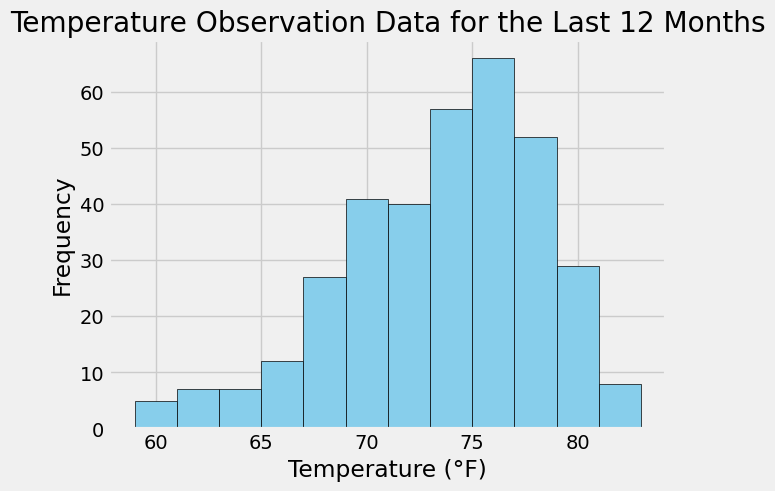

In [15]:
# Calculate the date 12 months ago from the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Query to get the TOBS data for the most active station in the last 12 months
tobs_data = session.query(Measurement.tobs)\
                    .filter(Measurement.station == most_active_station_id)\
                    .filter(Measurement.date >= one_year_ago)\
                    .all()

# Extract the TOBS values from the query results
tobs_values = [result[0] for result in tobs_data]

# Plot the results as a histogram
plt.hist(tobs_values, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Last 12 Months')
plt.grid(True)
plt.show()

In [16]:
# Close Session
session.close()

# Part 2: Design Your Climate App

In [17]:
from flask import Flask, jsonify

app = Flask(__name__)

# Homepage route to list all available routes
@app.route('/')
def home():
    routes = {
        "routes": [
            "/",
            "/api/v1.0/precipitation",
            "/api/v1.0/stations",
            "/api/v1.0/tobs",
            "/api/v1.0/<start>",
            "/api/v1.0/<start>/<end>"
        ]
    }
    return jsonify(routes)


### Convert precipation analysis results into a dictionary

In [18]:
# Query for the precipitation data for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()


# Define a Flask route handler function
@app.route('/precipitation')
def precipitation():
    
    # Convert the query results to a dictionary with date as the key and precipitation as the value
    precipitation_data = {date: prcp for date, prcp in results}

    # Filter the precipitation data for the last year
    last_year_precipitation = {date: prcp for date, prcp in precipitation_data.items() if date >= one_year_ago}

    # Return the filtered precipitation data as JSON
    return jsonify(last_year_precipitation)

### Return a JSON list of stations from the dataset

In [19]:
# Define a Flask route handler function
@app.route('/api/v1.0/stations')
def stations():
    # Return the list of stations as JSON
    return jsonify({'stations': stations_data})


### Return a JSON list of temperature observations 

In [20]:
# Define a Flask route handler function
@app.route('/api/v1.0/tobs')
def tobs():
    
# Query to get the TOBS data for the most active station in the last 12 months
    tobs_data = session.query(Measurement.tobs)\
                    .filter(Measurement.station == most_active_station_id)\
                    .filter(Measurement.date >= one_year_ago)\
                    .all()
    # Replace this line with your actual query
    # For example: temperature_data = db.query(...)

    # Return the list of temperature observations for the previous year as JSON
    return jsonify({'temperature_observations': tobs_data})

### Return a JSON list of the minimum temperature, the average temperature, and the maximum temperature

In [21]:

# Define a Flask route handler function for /api/v1.0/<start>
@app.route('/api/v1.0/<start>')
def temperature_start(start):
    # Perform query to calculate TMIN, TAVG, and TMAX for dates greater than or equal to the start date
    temperature_data = session.query.filter(Measurement.date >= start).all()

    # Process the temperature data to calculate TMIN, TAVG, and TMAX
    temperatures = [data.tobs for data in temperature_data]
    tmin = min(temperatures)
    tavg = sum(temperatures) / len(temperatures)
    tmax = max(temperatures)

    # Return the calculated statistics as JSON
    return jsonify({'TMIN': tmin, 'TAVG': tavg, 'TMAX': tmax})



# Define a Flask route handler function for /api/v1.0/<start>/<end>
@app.route('/api/v1.0/<start>/<end>')
def temperature_start_end(start, end):
    # Perform query to calculate TMIN, TAVG, and TMAX for dates between the start and end date (inclusive)
    temperature_data = session.query.filter(Measurement.date >= start, Measurement.date <= end).all()

    # Process the temperature data to calculate TMIN, TAVG, and TMAX
    temperatures = [data.tobs for data in temperature_data]
    tmin = min(temperatures)
    tavg = sum(temperatures) / len(temperatures)
    tmax = max(temperatures)

    # Return the calculated statistics as JSON
    return jsonify({'TMIN': tmin, 'TAVG': tavg, 'TMAX': tmax})



### Join the station and measurement tables to get combined data 

In [22]:
@app.route('/api/v1.0/data')
def get_data():
    # Join the station and measurement tables to get combined data
    query_result = session.session.query(Station, Measurement).filter(Station.station == Measurement.station).all()

    # Process the query result to extract relevant information
    data = []
    for station, measurement in query_result:
        data.append({
            'station_id': station.id,
            'station_name': station.name,
            'measurement_date': measurement.date,
            'temperature': measurement.temperature
        })

    # Convert the processed data to JSON using Flask jsonify
    return jsonify(data)

# Close Session

In [23]:
# Close Session
session.close()